<a href="https://colab.research.google.com/github/unicamp-dl/IA025_2022S1/blob/main/ex06/leonardo_lellis/Aula_6_Exerc%C3%ADcio_Leonardo_de_Lellis_Rossi_RA261900.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Treinamento de uma CNN no CIFAR 10

In [1]:
nome = "Leonardo de Lellis Rossi RA261900"

print(f'Meu nome é {nome}')

Meu nome é Leonardo de Lellis Rossi RA261900



https://app.neptune.ai/leolellisr/dl-ia025/e/DLIA-31/charts

Este exercicío consiste em implementar e treinar no CIFAR-10 vários blocos de uma Resnet seguido de uma camada linear de classificação.

## Importação das bibliotecas

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import random
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

from tqdm import tqdm
import math

In [3]:
 !pip install -U neptune-client
 import neptune.new as neptune

In [4]:
run = neptune.init(name= 'Ex. Aula 6', tags=['Aula 6', 'CIFAR10', 'Resnet', 'Dropout', 'CrossEntropy', 'SGD'],
    project="leolellisr/dl-ia025",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI1NjY1YmJkZi1hYmM5LTQ3M2QtOGU1ZC1iZTFlNWY4NjE1NDQifQ==",
)

debug = True

https://app.neptune.ai/leolellisr/dl-ia025/e/DLIA-31
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


## Fixando as seeds

In [5]:
random.seed(123)
np.random.seed(123)
torch.manual_seed(123)

## Dataset e dataloader

### Definição do tamanho do minibatch

In [6]:
batch_size = 50

## Download do CIFAR-10

In [7]:
!mkdir ./data

transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(),
     torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                             download=True, transform=transform)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                            download=True, transform=transform)


mkdir: cannot create directory ‘./data’: File exists
Files already downloaded and verified
Files already downloaded and verified


## Criação do dataloader

In [8]:
train_size = 40000
val_size = 10000
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

In [9]:
batch_size = 50

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print('Número de minibatches de trenamento:', len(train_dataloader))
print('Número de minibatches de validação:', len(val_dataloader))
print('Número de minibatches de teste:', len(test_dataloader))

x_train, y_train = next(iter(train_dataloader))
print("\nDimensões dos dados de um minibatch:", x_train.size())
print("Valores mínimo e máximo dos pixels: ", torch.min(x_train), torch.max(x_train))
print("Tipo dos dados das imagens:         ", type(x_train))
print("Tipo das classes das imagens:       ", type(y_train))

Número de minibatches de trenamento: 800
Número de minibatches de validação: 200
Número de minibatches de teste: 200

Dimensões dos dados de um minibatch: torch.Size([50, 3, 32, 32])
Valores mínimo e máximo dos pixels:  tensor(-1.) tensor(1.)
Tipo dos dados das imagens:          <class 'torch.Tensor'>
Tipo das classes das imagens:        <class 'torch.Tensor'>


## Implementando o Bloco Básico da Resnet

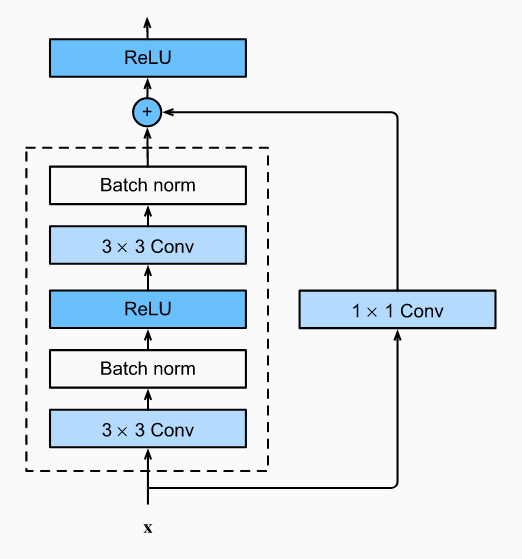

In [10]:
from torch import nn
from torch import Tensor

# https://pytorch.org/vision/0.8/_modules/torchvision/models/resnet.html

class MyBasicBlock(nn.Module):

# expected key(s) in state_dict: 
# "conv1.weight", "bn1.weight", "bn1.bias", "bn1.running_mean", "bn1.running_var", "bn1.num_batches_tracked", 
# "conv2.weight", "bn2.weight", "bn2.bias", "bn2.running_mean", "bn2.running_var", "bn2.num_batches_tracked", 
# "downsample.weight".

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        groups: int = 1,
        bias: bool = False,
        dilation: int = 1
    ) -> None:
        super().__init__()
        # Escreva seu código aqui.
        # downsample: residual conv 1x1
        self.downsample = nn.Conv2d(inplanes, planes, kernel_size=1, stride=stride, padding=0, groups=groups, bias=bias, dilation=dilation)
        # conv1:  conv1 3x3
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=3, stride=stride, bias=bias, padding=1)
        # conv2:  conv2 3x3
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, bias=bias, padding=1)
        self.bn1 = nn.BatchNorm2d(planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU()

    def forward(self, x: Tensor) -> Tensor:
        # Escreva seu código aqui.
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
           identity = self.downsample(x)

        out = out + identity

        out = self.relu(out)
        return out

## Compare se sua implementação está igual à do pytorch usando um exemplo aleatório

In [11]:
import torchvision

height_in = 5
width_in = 5
inplanes = 2
planes = 3
stride = 2

x = torch.rand(1, inplanes, height_in, width_in)

block = MyBasicBlock(inplanes=inplanes, planes=planes, stride=stride)

downsample = nn.Conv2d(inplanes, planes, kernel_size=1, stride=stride, padding=0, groups=1, bias=False, dilation=1)

block_pt = torchvision.models.resnet.BasicBlock(inplanes=inplanes, planes=planes, stride=stride, downsample=downsample)

# Usa os mesmos pesos para minha implementação e a do pytorch
block.load_state_dict(block_pt.state_dict())

out = block(x)
target_out = block_pt(x)

print(f'out:\n{out}')
print(f'target_out:\n{target_out}')

assert torch.allclose(out, target_out, atol=1e-6)

out:
tensor([[[[0.2084, 0.0000, 0.1053],
          [1.2176, 1.7145, 0.0000],
          [2.1509, 0.0000, 0.0000]],

         [[0.0000, 1.4478, 0.0000],
          [0.0000, 0.0000, 0.0000],
          [0.6579, 0.5231, 0.0000]],

         [[0.0000, 0.8983, 1.1205],
          [0.0000, 0.0000, 0.0225],
          [0.0000, 0.8017, 0.5681]]]], grad_fn=<ReluBackward0>)
target_out:
tensor([[[[0.2084, 0.0000, 0.1053],
          [1.2176, 1.7145, 0.0000],
          [2.1509, 0.0000, 0.0000]],

         [[0.0000, 1.4478, 0.0000],
          [0.0000, 0.0000, 0.0000],
          [0.6579, 0.5231, 0.0000]],

         [[0.0000, 0.8983, 1.1205],
          [0.0000, 0.0000, 0.0225],
          [0.0000, 0.8017, 0.5681]]]], grad_fn=<ReluBackward0>)


## Modelo

Implemente um modelo de classificação que será treinado no CIFAR-10.

In [12]:
# Ref.:
# https://pytorch.org/vision/0.9/_modules/torchvision/models/resnet.html

class Net(torch.nn.Module):
    def __init__(self, ):
        super(Net, self).__init__()
        # Escreva seu código aqui.

        self.layer1 = MyBasicBlock(inplanes=3, planes=32)
        self.layer2 = MyBasicBlock(inplanes=32, planes=64)

        self.max_pool = nn.MaxPool2d(3,3)
        
        self.input = 64*3*3
        self.dense_layer1 = nn.Linear(self.input, 64)
        self.dense_layer2 = nn.Linear(64, 10)
        self.relu = nn.ReLU()

        

    def forward(self, x):
        # Escreva seu código aqui.
        out = self.layer1(x)
        out = self.max_pool(out)
        out = self.layer2(out)
        out = self.max_pool(out)
        out = out.view(-1, self.input)
        out = self.dense_layer1(out)
        out = self.relu(out)
        out = self.dense_layer2(out)
        return out

## Treinamento

### Definição dos hiperparâmetros

In [13]:
n_epochs = 20
lr = 0.01

### Detectando a GPU

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [15]:
def evaluation(model, loader):
    # Escreva seu código aqui.
    model.eval()
    y_true = 0
    total_val_samples = 0
    for x, y in tqdm(loader, total=len(loader), desc='Evaluation'):
      x = x.to(device)
      y = y.to(device)
      out = model(x)
      y_true += (y == out.argmax(dim=1)).sum().item()
      total_val_samples += x.shape[0]
          
    mean_accuracy = y_true/total_val_samples
    run['val/mean_acc'].log(mean_accuracy) # Envia mean_accuracy para o Neptune.
    print(f'Accuracy: {mean_accuracy}')

### Laço de treinamento

In [16]:
model = Net()

model.to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr)

epochs = []
loss_history = []
loss_epoch_end = []
total_trained_samples = 0

# Primeira avaliação com pesos aleatórios
evaluation(model=model, loader=val_dataloader)

for i in range(n_epochs):
    model.train()
    for x_train, y_train in tqdm(train_dataloader, total=len(train_dataloader), desc='Training'):
        x_train = x_train.to(device)
        y_train = y_train.to(device)

        # predict da rede
        outputs = model(x_train)

        # calcula a perda
        loss = criterion(outputs, y_train)

        # zero, backpropagation, ajusta parâmetros pelo gradiente descendente
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_trained_samples += x_train.size(0)
        epochs.append(total_trained_samples / len(train_dataset))
        loss_history.append(loss.item())
        run['train/loss'].log(loss.item()) # Envia loss para o Neptune.

    loss_epoch_end.append(loss.item())
    run['train/loss_end'].log(loss.item()) # Envia loss para o Neptune.
    print(f'Epoch: {i:d}/{n_epochs - 1:d} Loss: {loss.item()}')

    # Chama a função de validação no final de cada época
    evaluation(model=model, loader=val_dataloader)

Evaluation: 100%|██████████| 200/200 [00:02<00:00, 75.71it/s]


Accuracy: 0.1137


Training: 100%|██████████| 800/800 [00:13<00:00, 60.60it/s]


Epoch: 0/19 Loss: 1.4330604076385498


Evaluation: 100%|██████████| 200/200 [00:02<00:00, 86.61it/s]


Accuracy: 0.5405


Training: 100%|██████████| 800/800 [00:13<00:00, 60.88it/s]


Epoch: 1/19 Loss: 1.3232001066207886


Evaluation: 100%|██████████| 200/200 [00:02<00:00, 83.95it/s]


Accuracy: 0.6073


Training: 100%|██████████| 800/800 [00:13<00:00, 57.26it/s]


Epoch: 2/19 Loss: 0.6006990671157837


Evaluation: 100%|██████████| 200/200 [00:02<00:00, 85.56it/s]


Accuracy: 0.6712


Training: 100%|██████████| 800/800 [00:14<00:00, 54.25it/s]


Epoch: 3/19 Loss: 0.8353202939033508


Evaluation: 100%|██████████| 200/200 [00:02<00:00, 72.90it/s]


Accuracy: 0.7129


Training: 100%|██████████| 800/800 [00:13<00:00, 59.44it/s]


Epoch: 4/19 Loss: 1.046812653541565


Evaluation: 100%|██████████| 200/200 [00:02<00:00, 88.50it/s]


Accuracy: 0.7097


Training: 100%|██████████| 800/800 [00:13<00:00, 59.88it/s]


Epoch: 5/19 Loss: 0.7705188989639282


Evaluation: 100%|██████████| 200/200 [00:02<00:00, 87.59it/s]


Accuracy: 0.7049


Training: 100%|██████████| 800/800 [00:13<00:00, 60.24it/s]


Epoch: 6/19 Loss: 0.2849688231945038


Evaluation: 100%|██████████| 200/200 [00:02<00:00, 87.61it/s]


Accuracy: 0.7173


Training: 100%|██████████| 800/800 [00:13<00:00, 59.48it/s]


Epoch: 7/19 Loss: 0.4387173056602478


Evaluation: 100%|██████████| 200/200 [00:02<00:00, 87.29it/s]


Accuracy: 0.737


Training: 100%|██████████| 800/800 [00:13<00:00, 60.38it/s]


Epoch: 8/19 Loss: 0.5287767648696899


Evaluation: 100%|██████████| 200/200 [00:02<00:00, 86.05it/s]


Accuracy: 0.7233


Training: 100%|██████████| 800/800 [00:13<00:00, 58.31it/s]


Epoch: 9/19 Loss: 0.28602951765060425


Evaluation: 100%|██████████| 200/200 [00:02<00:00, 84.83it/s]


Accuracy: 0.7314


Training: 100%|██████████| 800/800 [00:14<00:00, 55.32it/s]


Epoch: 10/19 Loss: 0.38090652227401733


Evaluation: 100%|██████████| 200/200 [00:02<00:00, 82.39it/s]


Accuracy: 0.7616


Training: 100%|██████████| 800/800 [00:13<00:00, 58.41it/s]


Epoch: 11/19 Loss: 0.2004333883523941


Evaluation: 100%|██████████| 200/200 [00:02<00:00, 81.31it/s]


Accuracy: 0.7488


Training: 100%|██████████| 800/800 [00:13<00:00, 57.36it/s]


Epoch: 12/19 Loss: 0.29863443970680237


Evaluation: 100%|██████████| 200/200 [00:02<00:00, 79.37it/s]


Accuracy: 0.7531


Training: 100%|██████████| 800/800 [00:14<00:00, 56.64it/s]


Epoch: 13/19 Loss: 0.3511996567249298


Evaluation: 100%|██████████| 200/200 [00:02<00:00, 81.54it/s]


Accuracy: 0.7526


Training: 100%|██████████| 800/800 [00:14<00:00, 56.77it/s]


Epoch: 14/19 Loss: 0.505845308303833


Evaluation: 100%|██████████| 200/200 [00:02<00:00, 83.53it/s]


Accuracy: 0.7544


Training: 100%|██████████| 800/800 [00:13<00:00, 57.98it/s]


Epoch: 15/19 Loss: 0.4491771459579468


Evaluation: 100%|██████████| 200/200 [00:02<00:00, 83.23it/s]


Accuracy: 0.7532


Training: 100%|██████████| 800/800 [00:13<00:00, 58.75it/s]


Epoch: 16/19 Loss: 0.33025044202804565


Evaluation: 100%|██████████| 200/200 [00:02<00:00, 85.02it/s]


Accuracy: 0.7431


Training: 100%|██████████| 800/800 [00:14<00:00, 56.29it/s]


Epoch: 17/19 Loss: 0.31941425800323486


Evaluation: 100%|██████████| 200/200 [00:02<00:00, 81.92it/s]


Accuracy: 0.7486


Training: 100%|██████████| 800/800 [00:14<00:00, 55.90it/s]


Epoch: 18/19 Loss: 0.3352903425693512


Evaluation: 100%|██████████| 200/200 [00:02<00:00, 86.09it/s]


Accuracy: 0.7394


Training: 100%|██████████| 800/800 [00:13<00:00, 59.40it/s]


Epoch: 19/19 Loss: 0.14262177050113678


Evaluation: 100%|██████████| 200/200 [00:02<00:00, 86.99it/s]

Accuracy: 0.7338


### Visualização usual da perda, somente no final de cada minibatch

Text(0.5, 0, 'época')

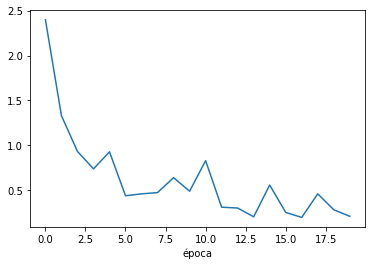

In [17]:
n_batches_train = len(train_dataloader)
plt.plot(epochs[::n_batches_train], loss_history[::n_batches_train])
plt.xlabel('época')

## Avaliação final no dataset de testes

In [18]:
evaluation(model=model, loader=test_dataloader)

Evaluation: 100%|██████████| 200/200 [00:02<00:00, 86.81it/s]

Accuracy: 0.7331


# Bonus Opcional

## Implementando o Dropout

In [19]:
# Refs.:
# https://pytorch.org/docs/stable/generated/torch.nn.functional.dropout.html
# https://pytorch.org/docs/stable/_modules/torch/nn/modules/dropout.html#Dropout
# Answer of Sahar Millis: https://stackoverflow.com/questions/54109617/implementing-dropout-from-scratch

class MyDropout(torch.nn.Module):
    def __init__(self, p: float):
        # Escreva seu código aqui.
        self.p = p

    def forward(self, x: Tensor, training: bool):
        # Escreva seu código aqui.
        if training: out = x*torch.bernoulli(torch.ones(x.shape)*self.p)
        else: out = x
        return out

    def __call__(self, x, training:bool):
      return self.forward(x, training)        

## Mostre que sua implementação traz resultados semelhantes à implementação do pytorch

In [20]:


p = 0.5
dropout = MyDropout(p=p)

x = torch.rand(16, 3, 32, 32)

out = dropout(x, training=True)
out_pt = torch.nn.functional.dropout(x, p=p, training=True)

mean_zeros = (out == 0).sum() / out.numel()
mean_zeros_pt = (out_pt == 0).sum() / out_pt.numel()

print(f'mean zeros: {mean_zeros}')
print(f'mean zeros pytorch: {mean_zeros_pt}')

assert math.isclose(mean_zeros, mean_zeros_pt, abs_tol=1e-2)

out = dropout(x, training=False)
target_out = torch.nn.functional.dropout(x, p=p, training=False, inplace=False)
assert torch.allclose(out, target_out, atol=1e-6)

mean zeros: 0.4979451596736908
mean zeros pytorch: 0.49554443359375


In [21]:
run.stop()

Shutting down background jobs, please wait a moment...
Done!


Waiting for the remaining 29 operations to synchronize with Neptune. Do not kill this process.


All 29 operations synced, thanks for waiting!
Explore the metadata in Neptune UI:
https://app.neptune.ai/leolellisr/dl-ia025/e/DLIA-31
